In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras_preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

In [2]:
model = InceptionV3(weights='imagenet')

In [3]:
def explain(image_path, model, preprocess, decode_predictions, size):
    # load image 
    img = image.load_img(image_path, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img = preprocess(x)

    pre_img = plt.imshow(img[0])
    img = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
      tape.watch(img)
      prediction = model(img)
      # get the loss of the predicted class
      loss = prediction[:, np.argmax(prediction[0])]

    gradient = tape.gradient(loss, img)[0]
    alpha = gradient
    gradient = tf.math.reduce_mean(tf.math.abs(gradient), axis=-1)

    # plot
    saliency_img = plt.imshow(gradient, cmap='jet')


    # get absolute values of alpha
    alpha = tf.math.abs(alpha) 
    # scale alpha to [0, 1]
    alpha = alpha / tf.math.reduce_max(alpha)

    # all values below threshold are set to 0 and all values above are set to 1

    alpha = tf.where(alpha >= 0.5, 1.0, 0.0)
    img = tf.reshape(img, (299, 299, 3))

    new_img2 = img + tf.random.uniform(img.shape, minval = -10, maxval = 10)*alpha

    # conevrt this to ndarray of shape (1, 480, 480, 3) and float32
    new_img2 = tf.reshape(new_img2, (1, 299, 299, 3))
    new_img2 = np.array(new_img2)
    new_img2 = new_img2.astype('float32')
    # plot
    ace_img = plt.imshow(new_img2[0])

    ace_pred = model(new_img2) 
    # convert ace_pred to a numpy array
    ace_pred = np.array(ace_pred)
    ace_pred = decode_predictions(ace_pred, top=3)[0]
    return ace_pred, saliency_img, ace_img, pre_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 121ms/step
[('n04590129', 'window_shade', 0.72812665), ('n02667093', 'abaya', 0.023772558), ('n04404412', 'television', 0.017953353)]
[('n09229709', 'bubble', 0.37225118), ('n02667093', 'abaya', 0.098600164), ('n04590129', 'window_shade', 0.076566845)]


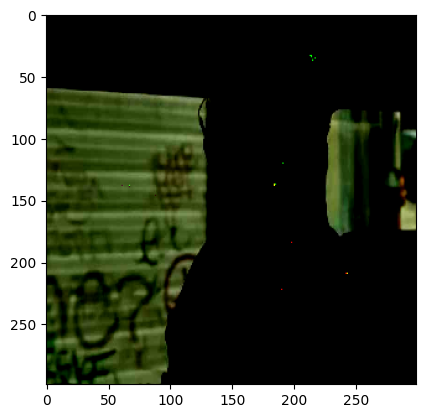

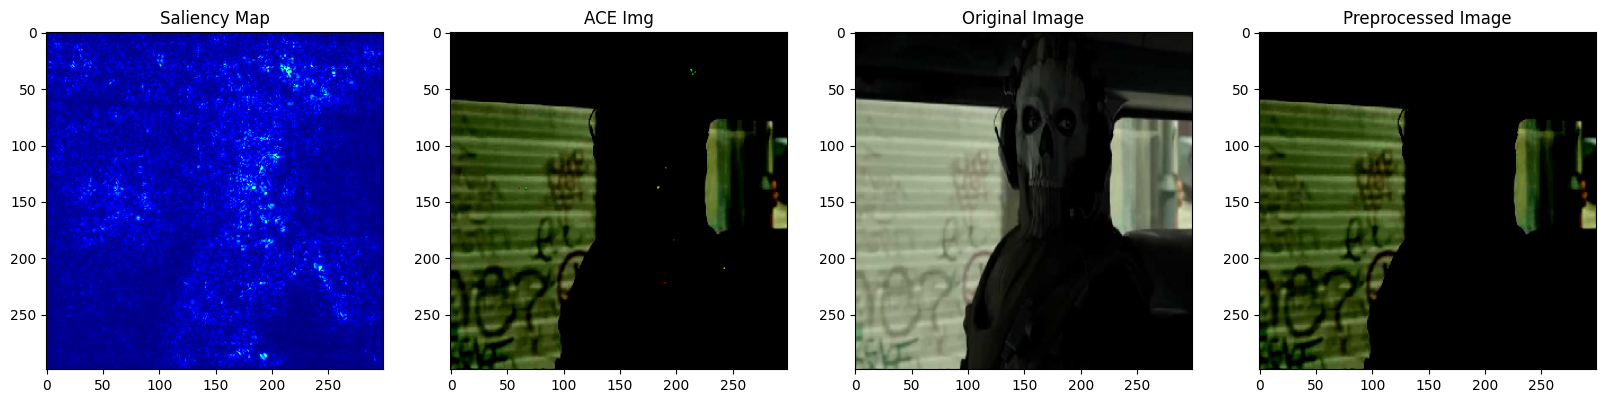

In [5]:
image_path = 'ghost.jpg'

ace_pred, saliency_img, ace_img, pre_img = explain(image_path, model, preprocess_input, decode_predictions, (299, 299))

y = image.load_img(image_path, target_size=(299, 299))
x = image.img_to_array(y)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# predict the image
pred = model.predict(x)
pred = decode_predictions(pred, top=3)[0]
print(pred)

print(ace_pred)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))

# Display each imshow object in a separate subplot
axs[0].imshow(saliency_img.get_array(), cmap='jet')
axs[1].imshow(ace_img.get_array())
axs[2].imshow(y)
axs[3].imshow(pre_img.get_array())
axs[0].set_title('Saliency Map')
axs[1].set_title('ACE Img')
axs[2].set_title('Original Image')
axs[3].set_title('Preprocessed Image')
plt.show()